In [ ]:
%load_ext autoreload

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
from utils.utils import show_images
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from typing import Callable
import os
import PIL.Image as Image
import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from typing import Optional


In [2]:
manual_seed = 999
print(f"Random Seed: {manual_seed}")
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

Random Seed: 999


In [3]:

latent_vector_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
%autoreload 2

from src.mod.plugins.early_stopping import EarlyStopping
from src.mod.datasets import CelebA
from src.mod.models import Classifier, Generator
from src.mod.datasets.utils import split_dataset


In [22]:
transform = transforms.Compose([
  transforms.Resize(64),
  transforms.CenterCrop(64),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = CelebA(
  dataset_path='../resources/datasets/celeba',
  image_directory='img_align_celeba',
  annotations_directory='annotations',
  max_image_count=500,
  image_transform=transform
)

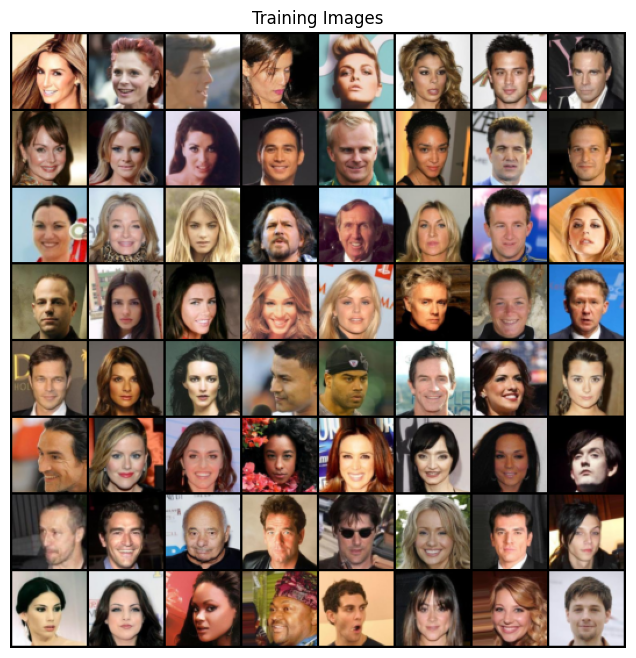

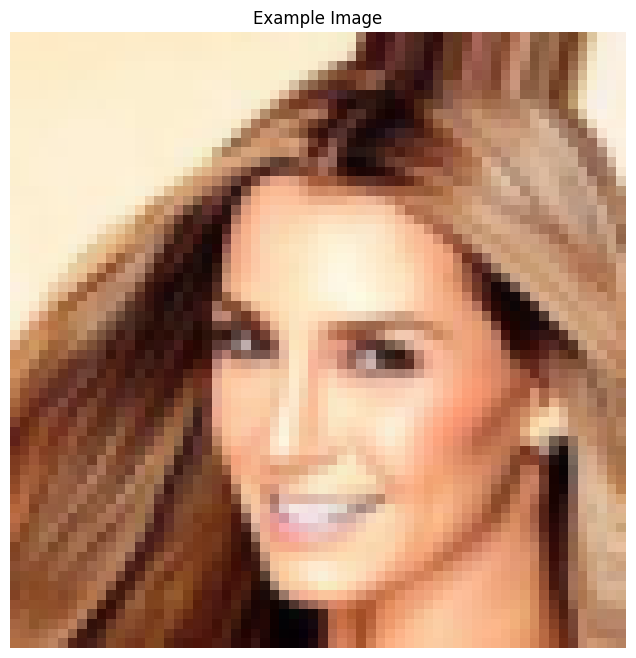

 1:  No - 5_o_Clock_Shadow
 2: Yes - Arched_Eyebrows
 3: Yes - Attractive
 4:  No - Bags_Under_Eyes
 5:  No - Bald
 6:  No - Bangs
 7:  No - Big_Lips
 8:  No - Big_Nose
 9:  No - Black_Hair
10:  No - Blond_Hair
11:  No - Blurry
12: Yes - Brown_Hair
13:  No - Bushy_Eyebrows
14:  No - Chubby
15:  No - Double_Chin
16:  No - Eyeglasses
17:  No - Goatee
18:  No - Gray_Hair
19: Yes - Heavy_Makeup
20: Yes - High_Cheekbones
21:  No - Male
22: Yes - Mouth_Slightly_Open
23:  No - Mustache
24:  No - Narrow_Eyes
25: Yes - No_Beard
26:  No - Oval_Face
27:  No - Pale_Skin
28: Yes - Pointy_Nose
29:  No - Receding_Hairline
30:  No - Rosy_Cheeks
31:  No - Sideburns
32: Yes - Smiling
33: Yes - Straight_Hair
34:  No - Wavy_Hair
35: Yes - Wearing_Earrings
36:  No - Wearing_Hat
37: Yes - Wearing_Lipstick
38:  No - Wearing_Necklace
39:  No - Wearing_Necktie
40: Yes - Young


In [6]:
def show_examples():
  dataloader = DataLoader(dataset, batch_size=64, num_workers=2)
  (images, _, _) = next(iter(dataloader))

  plt.figure(figsize=(8, 8))
  plt.axis("off")
  plt.title("Training Images")
  show_images(images)

def show_annotated_example():
  dataloader = DataLoader(dataset, batch_size=1, num_workers=2)
  (images, annotations, _) = next(iter(dataloader))
  annotations = annotations[0][0]

  plt.figure(figsize=(8, 8))
  plt.axis("off")
  plt.title("Example Image")
  show_images(images)
  for (i, column) in enumerate(dataset.annotations.columns):
    print(f"{i + 1:>2}: {annotations[i] > 0.9 and 'Yes' or 'No':>3} - {column}")

show_examples()
show_annotated_example()

In [ ]:
from tqdm import tqdm
from torch.optim import AdamW

def create_latent_vectors(size: int, channel_count: int, device: torch.device) -> Tensor:
  return torch.randn(size, channel_count, 1, 1, device=device, requires_grad=True)

def train_latent_vector_generator(
    generator: nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    epoch_count: int,
    save_to: str,
    on_train: Optional[Callable[[int, float, Tensor, Tensor, Tensor, list[str]], None]] = None,
    on_validate: Optional[Callable[[int, float, Tensor, Tensor, Tensor, list[str]], None]] = None,
    on_epoch: Optional[Callable[[int, float, float], None]] = None
):
  generator.train()

  optimizer = AdamW(generator.parameters())
  scheduler = ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
  early_stopping = EarlyStopping(
    generator,
    patience=5,
    verbose=True,
    save_to=save_to
  )
  criterion = nn.MSELoss()

  for epoch in range(1, epoch_count + 1):
    generator.train()
    train_loss = 0.0
    for batch_nr, (images, _, paths) in tqdm(
        enumerate(train_dataloader, 1),
        desc="Training",
        total=len(train_dataloader)
    ):
      images = images.to(device)
      optimizer.zero_grad()

      latent_vectors = create_latent_vectors(images.size(0), latent_vector_size, device)
      generated = generator(latent_vectors)
      loss = criterion(generated, images)

      loss.backward()
      optimizer.step()
      scheduler.step(loss)

      train_loss += loss.item()
      if on_train: on_train(batch_nr, loss, latent_vectors, generated, images, paths)
    train_loss /= len(train_dataloader)

    generator.eval()
    val_loss = 0.0
    for batch_nr, (images, _, paths) in tqdm(
        enumerate(val_dataloader, 1),
        desc="Validation",
        total=len(val_dataloader)
    ):
      images = images.to(device)
      latent_vectors = create_latent_vectors(images.size(0), latent_vector_size, device)
      generated = generator(latent_vectors)
      loss = criterion(generated, images)
      val_loss += loss.item()
      if on_validate: on_validate(batch_nr, loss, latent_vectors, generated, images, paths)
    val_loss /= len(val_dataloader)

    if early_stopping.step(val_loss): break
    if on_epoch: on_epoch(epoch, train_loss, val_loss)
  generator.eval()
  return generator

dataframe: pd.DataFrame = pd.DataFrame()
generator = Generator(latent_vector_size, 64, 3, with_weights=torch.load('generator.pt'))
generator.to(device)
train_dataloader, validation_dataloader = split_dataset(dataset, 0.8)


# every epoch show generated images grid
def on_epoch(epoch, train_loss, val_loss):
  print(f"Epoch {epoch}: Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
  vec = create_latent_vectors(64, latent_vector_size, device)
  generated = generator(vec)
  show_images(generated)

train_latent_vector_generator(
  generator,
  train_dataloader,
  validation_dataloader,
  epoch_count=20,
  save_to="generator_checkpoint.pt",
  on_epoch=on_epoch
)


In [ ]:
# Create latent vectors for all images in the dataset by running the generator

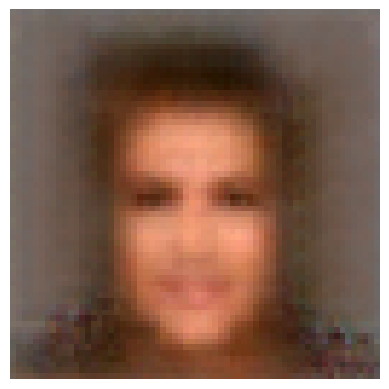

In [19]:
vec = create_latent_vectors(1, latent_vector_size, device)
generated = generator(vec)

show_images(generated)


In [ ]:
dataframe

In [ ]:
vector = (
  torch.tensor(pd.to_numeric(dataframe.loc[0][0:100]).to_numpy(), device=device)
  .unsqueeze(1).unsqueeze(1).unsqueeze(0).float()
)
path = dataframe.loc[0]['img']

real_image = Image.open(f"../resources/datasets/celeba/img_align_celeba/{path}").convert("RGB")
real_image = transform(real_image).unsqueeze(0).to(device)

show_images(generator(vector), real_image)

In [ ]:
latent_vector = torch.randn(64, latent_vector_size, 1, 1, device=device, requires_grad=True)
generated = generator(latent_vector)

show_images(generated)

In [ ]:
dataframe.to_csv('latent_vectors.csv')

In [ ]:
dataframe = pd.read_csv('latent_vectors.csv')

In [ ]:
# Read annotations from celeba dataset
annotations = pd.read_csv('../resources/datasets/celeba/list_attr_celeba.txt', skiprows=1, delim_whitespace=True, index_col=None)
annotations.head()

In [ ]:
# Test classifier on latent space from the dataset and show real image and predicted attributes
(vector, attributes) = classifier_dataset[0]
vector = torch.tensor(vector).to(device)
image = Image.open(f"../resources/datasets/celeba/img_align_celeba/000001.jpg").convert("RGB")
classified = classifier(vector).cpu().detach().numpy()
error = np.abs(classified - attributes)

for i, err in enumerate(error[0]):
  print(f"{i:>2}: {err:.2f} - {annotations.columns[i]}")
  plt.imshow(image)


In [ ]:
latent_vector = torch.randn(1, latent_vector_size, 1, 1, device=device, requires_grad=True)

generated = generator(latent_vector)
classified = classifier(latent_vector.resize(1, latent_vector_size)).cpu().detach().numpy()

for i, err in enumerate(classified[0]):
  print(f"{i:>2}: {err:.2f} - {annotations.columns[i]}")
show_images(generated)


In [ ]:
def find_attribute_direction(latent_vectors, classifier, target_scores):
  latent_vectors = latent_vectors.requires_grad_()
  attribute_scores = classifier(latent_vectors)
  loss = torch.nn.functional.mse_loss(attribute_scores, target_scores)
  loss.backward()
  print(latent_vectors.grad)
  attribute_direction = latent_vectors.grad
  return attribute_direction.mean(dim=0)

def steer_away_from_attribute(latent_vector, direction, intensity=1.0):
  return latent_vector - intensity * direction

latent_vectors = torch.randn(32, latent_vector_size).to(device)
target_scores = torch.ones(32, 40).to(device)

latent_vectors = latent_vectors.resize(32, latent_vector_size)
direction = find_attribute_direction(latent_vectors, classifier, target_scores)
adjusted_latent_vector = steer_away_from_attribute(latent_vectors, direction, intensity=1)

real_images = generator(latent_vectors.resize(32, latent_vector_size, 1, 1))
move_images = generator(adjusted_latent_vector.resize(32, latent_vector_size, 1, 1))

show_images(real_images, move_images)
